In [1]:
#import libs
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib import rcParams
from matplotlib import patches
import xarray as xr
import scipy.io
import astropy.constants as const
#rcParams['text.usetex'] = True
#rcParams['font.family'] = 'serif'
import pandas as pd
#from IPython.display import display, Math
from astropy.modeling import models, fitting, Fittable1DModel, Parameter
from scipy.optimize import curve_fit
import emcee
from num2tex import num2tex
from fitting_template import myGaussian1D
plt.style.use('science')
rcParams['axes.linewidth'] = 1.2
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'cm'

In [2]:
%store -r data_195_erg
%store -r wvl_195
%store -r data_195_erg_err

In [3]:
def lnlike2(p,x,y,yerr):
    intensity, mean, fwhm, bg = p
    g_model = myGaussian1D(intensity=intensity, mean=mean, fwhm = fwhm,bg = bg,stray_int=0.01797782,stray_fwhm=0.0951304,stray_wvl = 195.05354)
    model = g_model(x)
    sigma2 = yerr ** 2 # + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))   

def lnprior2(p,p0):
    intensity, mean, fwhm, bg = p
    intensity_0, mean_0, fwhm_0, bg_0 = p0
    #if np.abs((bg-bg_0)/bg_0)>2:
    #    return -np.inf
    #if np.abs(mean - mean_0)>0.1:
    #    return -np.inf
    #if np.abs((stddev-stddev_0)/stddev_0)>0.5:
    #    return -np.inf
    #if np.abs((amp-amp_0)/amp_0)>0.5:
    #    return -np.inf
    if fwhm > 0.2:
        return -np.inf
    #if log_f > -1.6:
    #    return -np.inf
    return 0.0

def lnprob2(p,p0, x, y, yerr):
    lp = lnprior2(p,p0)
    if yerr is None:
        yerr = np.sqrt(y*600.0)/600.0
    return lp + lnlike2(p, x, y, yerr) if np.isfinite(lp) else -np.inf   

In [4]:
mcmc_result = np.zeros(5)
mcmc_result_err = np.zeros((2,5))
#g_init = myGaussian1D(amplitude=np.max(data_195_erg[16,:]), mean=wvl_195[np.argmax(data_195_erg[16,:])], stddev = self.result[ii,2],bg = 0.)
#fit_g = fitting.LevMarLSQFitter()
p0 = np.array([np.max(data_195_erg[2,:])*0.03*1.4, wvl_195[np.argmax(data_195_erg[2,:])], 0.08, 0.1])
ndim = len(p0)
nwalkers = 32
p_start = [p0 + np.array([1e-4*np.random.randn()*p0[0],1e-4*np.random.randn(),
1e-4*np.random.randn(),1e-4*p0[3]*np.random.randn()])
    for i in range(nwalkers)]

#p_start = [p0 + p0*1e-3*np.random.randn(ndim)
#    for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, 
                                args=(p0,wvl_195,data_195_erg[2,:],data_195_erg_err[2,:]))

#print("Running burn-in...")
p_start, _, _ = sampler.run_mcmc(p_start, 1000,progress=True)
sampler.reset()

#print("Running production...")
sampler.run_mcmc(p_start, 4000,progress=True)

flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
for jj in range(ndim ):
    mcmc = np.percentile(flat_samples[:, jj], [50-68/2, 50, 50+68/2])
    q = np.diff(mcmc)
    #print(type(np.array(mcmc[1])))
    mcmc_result[jj] = mcmc[1]
    mcmc_result_err[:,jj] = np.array([q[0],q[1]])

100%|██████████| 4000/4000 [01:47<00:00, 37.13it/s]


In [8]:
mcmc_result

array([ 1.79124024e-01,  1.95064253e+02,  1.00915458e-01,  1.70723111e-01,
       -2.22800617e+00])

In [133]:
mcmc_result

array([ 1.79156142e-01,  1.95065388e+02,  1.00118969e-01,  1.61648368e-01,
       -2.18332284e+00])

In [129]:
mcmc_result_err[:,4]

array([0.27872969, 0.33128413])

In [125]:
from scipy.integrate import simps
simps(x = wvl_195,y = data_195_erg[16,:]*0.765 - 0.16)/np.sqrt(np.pi)

0.10370371347969273

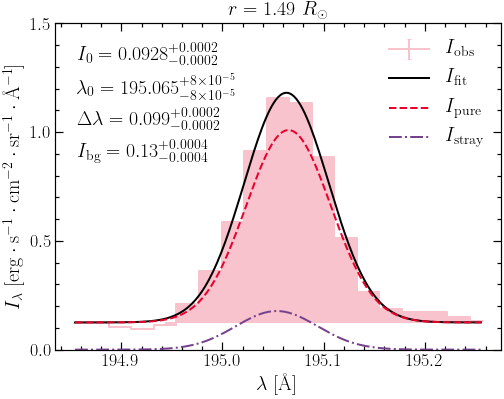

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
#ln1 = ax.errorbar(wvl_195,data_195_erg[2,:],yerr = data_195_erg_err[2,:],ds='steps-mid',color="#F596AA",capsize=2,lw=2,label=r"$I_{\rm obs}$")
ax.fill_between(wvl_195[4:],data_195_erg[2,4:],mcmc_result[3],step='mid',color="#F8C3CD")
g_fit = myGaussian1D(intensity=mcmc_result[0], mean=mcmc_result[1], fwhm = mcmc_result[2],bg = mcmc_result[3],stray_int=0.01797782,stray_fwhm=0.0951304,
                     stray_wvl=195.05354)
g_pure = myGaussian1D(intensity=mcmc_result[0], mean=mcmc_result[1], fwhm = mcmc_result[2],bg = mcmc_result[3],stray_int=0.,stray_fwhm=1.,stray_wvl=0)
g_stray = myGaussian1D(intensity=0.01797782, mean=195.05354, fwhm = 0.0951304,bg = 0,stray_int=0.,stray_fwhm=1.,stray_wvl=0)
wvl_195_plot = np.linspace(wvl_195[0],wvl_195[-1],201)
ln2, = ax.plot(wvl_195_plot,g_fit(wvl_195_plot),color="black",ls="-",lw=2,label=r"$I_{\rm fit}$")
ln3, = ax.plot(wvl_195_plot,g_pure(wvl_195_plot),color="#E9002D",ls="--",lw=2,label=r"$I_{\rm pure}$")
ln4, = ax.plot(wvl_195_plot,g_stray(wvl_195_plot),color="#77428D",ls="-.",lw=2,label=r"$I_{\rm stray}$")
ln1 = ax.errorbar(wvl_195,data_195_erg[2,:],yerr = data_195_erg_err[2,:],ds='steps-mid',
                  color="#F8C3CD",capsize=2,lw=2,label=r"$I_{\rm obs}$",zorder=0)
ax.set_xlabel(r' $\lambda\ [\mathrm{\AA}]$',fontsize=20)
ax.set_ylabel(r' $I_\lambda\ [\mathrm{erg\cdot s^{-1} \cdot cm^{-2} \cdot sr^{-1} \cdot \AA^{-1}}]$',fontsize=20)
ax.set_ylim(0,1.5)
ax.set_yticks([0,0.5,1,1.5])
ax.set_xticks([194.9,195,195.1,195.2])
ax.tick_params(labelsize=18)
ax.tick_params(which="major",width=1.2,length=8)
ax.tick_params(which="minor",width=1.2,length=4)
ax.set_title(r'$r = 1.49\ R_\odot$',fontsize=20)
ax.text(0.05,0.9,r'$I_0 = {:.3g}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[0]),num2tex(mcmc_result_err[0,0]),num2tex(mcmc_result_err[1,0])),
        ha = 'left',va = 'center', color = 'black',fontsize = 20,linespacing=1.5,transform=ax.transAxes)
ax.text(0.05,0.8,r'$\lambda_0 = {:.6g}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[1]),num2tex(mcmc_result_err[0,1]),num2tex(mcmc_result_err[1,1])),
        ha = 'left',va = 'center', color = 'black',fontsize = 20,linespacing=1.5,transform=ax.transAxes)
ax.text(0.05,0.7,r'$\Delta \lambda = {:.3f}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[2]),num2tex(mcmc_result_err[0,2]),num2tex(mcmc_result_err[1,2])),
        ha = 'left',va = 'center', color = 'black',fontsize = 20,linespacing=1.5,transform=ax.transAxes)
ax.text(0.05,0.6,r'$I_{{\rm bg}} = {:.2g}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[3]),num2tex(mcmc_result_err[0,3]),num2tex(mcmc_result_err[1,3])),
        ha = 'left',va = 'center', color = 'black',fontsize = 20,linespacing=1.5,transform=ax.transAxes)
#ax.text(194.85,1.4-0.8*1.5/2.3,r'$\ln f = {:.2g}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[4]),num2tex(mcmc_result_err[0,4]),num2tex(mcmc_result_err[1,4])),
#        ha = 'left',va = 'center', color = 'black',fontsize = 20,linespacing=1.5)

leg = [ln1,ln2,ln3,ln4]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 20,frameon=False)
#plt.subplots_adjust(bottom = 0.13,left=0.12,top=0.94,right=0.97)
plt.savefig(fname = '../figs/fit_example_hc.pdf', dpi = 300, format = 'pdf')

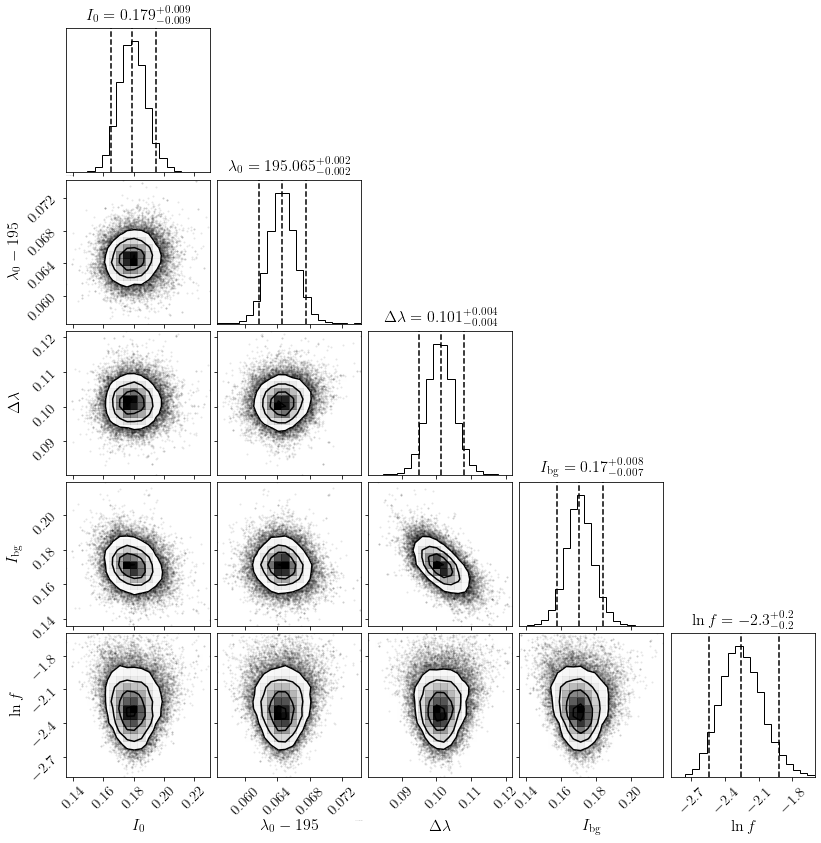

In [20]:
import corner

fig = corner.corner(flat_samples, labels=[r"$I_{0}$",r"$\lambda_0 - 195$ ",r"$\Delta \lambda$ ",r"$I_{\rm bg}$",r"$\ln f$"],
                   quantiles=[0.05, 0.50, 0.95])
axes = np.array(fig.axes).reshape((ndim, ndim))
axes[0,0].set_title(r'$I_0 = {:.3g}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[0]),num2tex(mcmc_result_err[0,0]),num2tex(mcmc_result_err[1,0])),fontsize=16)
axes[1,1].set_title(r'$\lambda_0 = {:.6g}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[1]),num2tex(mcmc_result_err[0,1]),num2tex(mcmc_result_err[1,1])),
                    fontsize=16)
axes[2,2].set_title(r'$\Delta \lambda = {:.3f}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[2]),num2tex(mcmc_result_err[0,2]),num2tex(mcmc_result_err[1,2])),
                   fontsize=16)
axes[3,3].set_title(r'$I_{{\rm bg}} = {:.2g}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[3]),num2tex(mcmc_result_err[0,3]),num2tex(mcmc_result_err[1,3])),
                   fontsize=16)
axes[4,4].set_title(r'$\ln f = {:.2g}_{{-{:.1g}}}^{{+{:.1g}}}$'.format(num2tex(mcmc_result[4]),num2tex(mcmc_result_err[0,4]),num2tex(mcmc_result_err[1,4])),
                   fontsize=16)
for ax_ in axes.flatten():
    ax_.tick_params(labelsize=15)
    ax_.xaxis.label.set_size(16)
    ax_.yaxis.label.set_size(16)
    ax_.yaxis.get_offset_text().set_fontsize(0)
    ax_.xaxis.get_offset_text().set_fontsize(0)
plt.savefig(fname = '../figs/fit_corner.pdf', dpi = 300, format = 'pdf')